In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import os
import neptune
from neptune.utils import stringify_unsupported

import scalpDeepModels as sdm

import importlib

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [19]:
stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta.npz'
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain.npz'
timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta.npz'

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model.pth'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [3]:
epochs = 5000
batch_size = 1024
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 5000

# UTILITY FUNCTIONS

In [4]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

# LOAD NUMPY DATA ARRAYS

In [5]:
dataSwitch = 'time'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

In [6]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32


# DEFINE OR LOAD THE MODEL

In [48]:
# DEFINE MODEL

modelLoadFlag = False

if modelLoadFlag == True:
    model = torch.load(modelPath)
    bestTestLoss = sdm.test(validDataLoader, model, loss_fn)
else:
    importlib.reload(scalpDeepModels)
    # DEFINE ARCHITECTURE HERE
    hiddenLayerSizes = [512,512,512,512,512]
    
    '''
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = sdm.listToOrderedDict(layerSizeList)
    model = sdm.NeuralNetwork(layerOrderedDict)
    '''
    inputSize = trainXTensor.shape[1]
    model = sdm.NeuralNetwork(inputSize, hiddenLayerSizes)
    bestTestLoss = float('inf')
    
print("Number of parameters: ", sdm.count_parameters(model))
model = model.to(device)
print(model)

Number of parameters:  3951105
NeuralNetwork(
  (model): Sequential(
    (in): Linear(in_features=5655, out_features=512, bias=True)
    (bn0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l0): Linear(in_features=512, out_features=512, bias=True)
    (r0): ReLU()
    (d0): Dropout(p=0.5, inplace=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (r1): ReLU()
    (d1): Dropout(p=0.5, inplace=False)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (r2): ReLU()
    (d2): Dropout(p=0.5, inplace=False)
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l3): Linear(in_features=512, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=1, bias=True)
  )
)


# TRAIN (LOG DATA TO NEPTUNE)

In [49]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model),
    "numParameters": sdm.count_parameters(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = sdm.train(trainDataLoader, model, loss_fn, optimizer, device)
    test_loss = sdm.test(validDataLoader, model, loss_fn, device)
    
    if test_loss < bestTestLoss:
        noImprovementCount = 0
        bestTestLoss = test_loss
        torch.save(model, modelPath)
        run["model_best"].upload(modelPath)
        run["best_test_loss"] =  bestTestLoss
        run["best_test_epoch"] = t
        print("\nSaved a new best model!\n")
    else:
        noImprovementCount = noImprovementCount + 1
        
    run["train/loss"].append(train_loss)
    run["test/loss"].append(test_loss)
    
    if noImprovementCount >= patience:   
        print("Early stopping invoked....")
        break
        
run.stop()
print("Done!")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-44
Epoch 1
-------------------------------
loss: 0.732735  [ 1024/176128]
Test Error: 
 Avg loss: 0.665150 


Saved a new best model!

Epoch 2
-------------------------------
loss: 0.718549  [ 1024/176128]
Test Error: 
 Avg loss: 0.655137 


Saved a new best model!

Epoch 3
-------------------------------
loss: 0.664051  [ 1024/176128]
Test Error: 
 Avg loss: 0.646568 


Saved a new best model!

Epoch 4
-------------------------------
loss: 0.656500  [ 1024/176128]
Test Error: 
 Avg loss: 0.589854 


Saved a new best model!

Epoch 5
-------------------------------
loss: 0.640747  [ 1024/176128]
Test Error: 
 Avg loss: 0.590857 

Epoch 6
-------------------------------
loss: 0.613030  [ 1024/176128]
Test Error: 
 Avg loss: 0.624704 

Epoch 7
-------------------------------
loss: 0.634952  [ 1024/176128]
Test Error: 
 Avg loss: 0.586279 


Saved a new best model!

Epoch 8
-------------------------------
loss: 0.603139  [ 1024/1761

Test Error: 
 Avg loss: 0.453949 

Epoch 65
-------------------------------
loss: 0.457613  [ 1024/176128]
Test Error: 
 Avg loss: 0.431718 

Epoch 66
-------------------------------
loss: 0.415496  [ 1024/176128]
Test Error: 
 Avg loss: 0.425239 


Saved a new best model!

Epoch 67
-------------------------------
loss: 0.406267  [ 1024/176128]
Test Error: 
 Avg loss: 0.432428 

Epoch 68
-------------------------------
loss: 0.427779  [ 1024/176128]
Test Error: 
 Avg loss: 0.442643 

Epoch 69
-------------------------------
loss: 0.422545  [ 1024/176128]
Test Error: 
 Avg loss: 0.436750 

Epoch 70
-------------------------------
loss: 0.423958  [ 1024/176128]
Test Error: 
 Avg loss: 0.431563 

Epoch 71
-------------------------------
loss: 0.442574  [ 1024/176128]
Test Error: 
 Avg loss: 0.429696 

Epoch 72
-------------------------------
loss: 0.414384  [ 1024/176128]
Test Error: 
 Avg loss: 0.430438 

Epoch 73
-------------------------------
loss: 0.443001  [ 1024/176128]
Test Error:

Test Error: 
 Avg loss: 0.414009 

Epoch 139
-------------------------------
loss: 0.430402  [ 1024/176128]
Test Error: 
 Avg loss: 0.415346 

Epoch 140
-------------------------------
loss: 0.416021  [ 1024/176128]
Test Error: 
 Avg loss: 0.412065 


Saved a new best model!

Epoch 141
-------------------------------
loss: 0.402227  [ 1024/176128]
Test Error: 
 Avg loss: 0.413110 

Epoch 142
-------------------------------
loss: 0.410014  [ 1024/176128]
Test Error: 
 Avg loss: 0.415140 

Epoch 143
-------------------------------
loss: 0.399222  [ 1024/176128]
Test Error: 
 Avg loss: 0.419697 

Epoch 144
-------------------------------
loss: 0.398790  [ 1024/176128]
Test Error: 
 Avg loss: 0.419905 

Epoch 145
-------------------------------
loss: 0.402243  [ 1024/176128]
Test Error: 
 Avg loss: 0.421864 

Epoch 146
-------------------------------
loss: 0.434986  [ 1024/176128]
Test Error: 
 Avg loss: 0.417836 

Epoch 147
-------------------------------
loss: 0.387368  [ 1024/176128]
Te

KeyboardInterrupt: 

# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


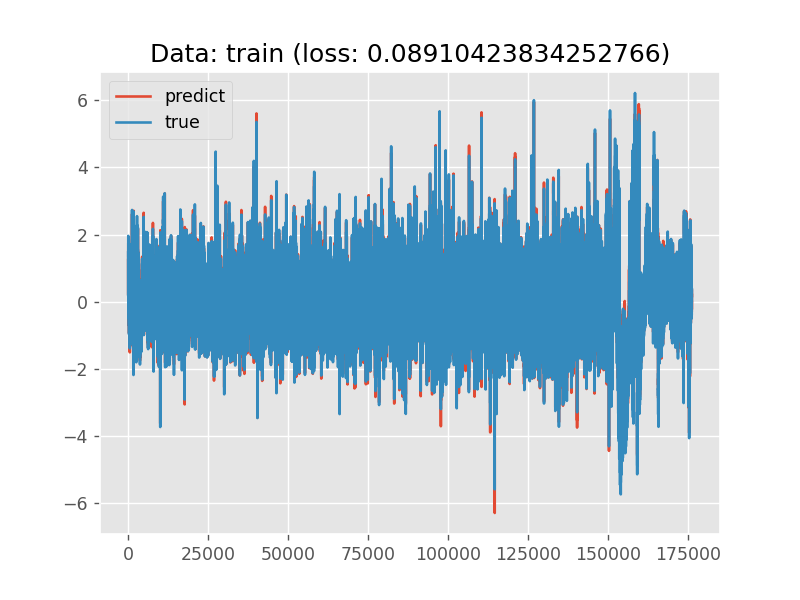

In [10]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = True
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'

model.to('cpu')
predict = model(x).cpu().detach().numpy()
model.to(device)

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# SCRATCH

In [ ]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

In [30]:
# HOW TO GRAB DATA FROM NEPTUNE

project = neptune.init_project(project="jettinger35/predictScalp")
df = project.fetch_runs_table().to_pandas()
df[['sys/id','best_test_loss']]

https://new-ui.neptune.ai/jettinger35/predictScalp/


sys/id  best_test_loss
0  PRED-38        0.398955
1  PRED-35        0.403722
2  PRED-34        0.417772
4  PRED-32        0.408214
5  PRED-31        0.409690
6  PRED-30             NaN
3  PRED-33             NaN

In [21]:
from scipy.signal import get_window
a = get_window(('tukey', .25), nperseg)
a

array([0.        , 0.00960736, 0.03806023, 0.08426519, 0.14644661,
       0.22221488, 0.30865828, 0.40245484, 0.5       , 0.59754516,
       0.69134172, 0.77778512, 0.85355339, 0.91573481, 0.96193977,
       0.99039264, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [ ]:
'''
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('bn%s' % str(i), nn.BatchNorm1d(sizeList[i])))
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
'''